In [19]:
# GEREKLİ KÜTÜPHANELERİ İÇE AKTARMA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # DataFrame'i güzel göstermek için

# Sklearn Kütüphaneleri
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, precision_score, precision_recall_curve
)

# VERİ YÜKLEME

print("VERİLER YÜKLENİYOR")
try:
    # Lütfen dosya adlarını Colab ortamınızdaki yollara göre güncelleyin.
    X_train = pd.read_csv('/content/drive/MyDrive/veri madenciliği 2/X_train.csv')
    y_train = pd.read_csv('/content/drive/MyDrive/veri madenciliği 2/y_train.csv').values.ravel()
    X_test = pd.read_csv('/content/drive/MyDrive/veri madenciliği 2/X_test.csv')
    y_test = pd.read_csv('/content/drive/MyDrive/veri madenciliği 2/y_test.csv').values.ravel()
    print(f" Veri Hazır: X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
except FileNotFoundError:
    print(" HATA: csv dosyaları bulunamadı. Lütfen dosya yollarını kontrol edin.")
    raise

VERİLER YÜKLENİYOR
 Veri Hazır: X_train.shape=(81410, 132), y_train.shape=(81410,)


In [20]:
# SONUÇ YÖNETİMİ VE YARDIMCI FONKSİYONLAR
# Sonuç Tablosunu Başlatma
global results_df
results_df = pd.DataFrame(columns=['Aşama', 'Model', 'Parametreler', 'Accuracy', 'Recall', 'F1 Score'])

# Sonuç Ekleme Fonksiyonu
def add_result(stage, model_name, params, y_true, y_pred):
    global results_df
    new_row = {
        'Aşama': stage,
        'Model': model_name,
        'Parametreler': params,
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Recall': round(recall_score(y_true, y_pred), 4),
        'F1 Score': round(f1_score(y_true, y_pred), 4)
    }
    results_df.loc[len(results_df)] = new_row

    print(f"\n {stage} SONUCU ({model_name})")
    print(f"   Parametreler: {params}")
    print(f"   Accuracy: {new_row['Accuracy']}  |  Recall: {new_row['Recall']}  |  F1 Score: {new_row['F1 Score']}")
    print("-" * 60)

# Yan Yana Karışıklık Matrisi Çizme Fonksiyonu
def plot_side_by_side_cm(y_test, pred1, name1, pred2, name2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # CM 1
    sns.heatmap(confusion_matrix(y_test, pred1), annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    # pos_label=1, Recall'un pozitif sınıf (risk) için hesaplandığından emin olur
    axes[0].set_title(f"{name1}\nRecall: {recall_score(y_test, pred1, pos_label=1):.2f}")
    axes[0].set_xlabel("Tahmin")
    axes[0].set_ylabel("Gerçek")

    # CM 2
    sns.heatmap(confusion_matrix(y_test, pred2), annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[1])
    axes[1].set_title(f"{name2}\nRecall: {recall_score(y_test, pred2, pos_label=1):.2f}")
    axes[1].set_xlabel("Tahmin")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [21]:
# 1. BASELINE MODELLER
print("\n BASELINE MODELLER ÇALIŞIYOR")

# Veri Ölçekleme (Standart Ölçekleme)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# Gaussian Naive Bayes (Standart Veri Üzerinde)
gnb_base = GaussianNB()
gnb_base.fit(X_train_std, y_train)
y_pred_gnb_base = gnb_base.predict(X_test_std)
add_result('1. Baseline', 'GaussianNB', 'Default', y_test, y_pred_gnb_base)

# Logistic Regression (Standart Veri Üzerinde)
lr_base = LogisticRegression(random_state=42, solver='liblinear')
lr_base.fit(X_train_std, y_train)
y_pred_lr_base = lr_base.predict(X_test_std)
add_result('1. Baseline', 'LogisticRegression', 'Default (C=1.0)', y_test, y_pred_lr_base)


 BASELINE MODELLER ÇALIŞIYOR

 1. Baseline SONUCU (GaussianNB)
   Parametreler: Default
   Accuracy: 0.1311  |  Recall: 0.9987  |  F1 Score: 0.2041
------------------------------------------------------------

 1. Baseline SONUCU (LogisticRegression)
   Parametreler: Default (C=1.0)
   Accuracy: 0.8881  |  Recall: 0.0163  |  F1 Score: 0.0315
------------------------------------------------------------


In [22]:
# FEATURE ENGINEERING / BOYUT AZALTMA

### SELECT K BEST (Mutual Info)
print("\n FEATURE SELECTION: SELECT K BEST")
# Mutual Info için veriyi MinMax ile ölçekleyip seçimi yapıyoruz
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)

selector = SelectKBest(score_func=mutual_info_classif, k=50) # En iyi 50 özellik seçiliyor
selector.fit(X_train_mm, y_train)
cols = selector.get_support(indices=True)
print(f"Seçilen Özellik Sayısı (KBest): {len(cols)}")

# KBest ile küçültülmüş veride test (Standart Ölçeklenmiş)
X_train_sel_std = X_train_std[:, cols]
X_test_sel_std = X_test_std[:, cols]

# Modelleri KBest verisi üzerinde test et
gnb_sel = GaussianNB()
gnb_sel.fit(X_train_sel_std, y_train)
y_pred_gnb_sel = gnb_sel.predict(X_test_sel_std)
add_result('2.1 Feature Sel.', 'GaussianNB', 'Top 50 Features', y_test, y_pred_gnb_sel)

lr_sel = LogisticRegression(random_state=42, solver='liblinear')
lr_sel.fit(X_train_sel_std, y_train)
y_pred_lr_sel = lr_sel.predict(X_test_sel_std)
add_result('2.1 Feature Sel.', 'LogisticRegression', 'Top 50 Features', y_test, y_pred_lr_sel)


### PCA (Temel Bileşenler Analizi)
print("\n BOYUT AZALTMA: PCA ")
# %90 varyansı açıklayan bileşen sayısını bulalım
pca = PCA(n_components=0.90) # Standart Ölçeklenmiş veri kullanılıyor
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print(f"PCA ile yeni boyut: {X_train_pca.shape[1]}")

# Modelleri PCA verisi üzerinde test et
gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca, y_train)
y_pred_gnb_pca = gnb_pca.predict(X_test_pca)
add_result('2.2 Boyut Azaltma', 'GaussianNB', f'PCA (n={pca.n_components_})', y_test, y_pred_gnb_pca)

lr_pca = LogisticRegression(random_state=42, solver='liblinear')
lr_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = lr_pca.predict(X_test_pca)
add_result('2.2 Boyut Azaltma', 'LogisticRegression', f'PCA (n={pca.n_components_})', y_test, y_pred_lr_pca)


 FEATURE SELECTION: SELECT K BEST
Seçilen Özellik Sayısı (KBest): 50

 2.1 Feature Sel. SONUCU (GaussianNB)
   Parametreler: Top 50 Features
   Accuracy: 0.1353  |  Recall: 0.9947  |  F1 Score: 0.2043
------------------------------------------------------------

 2.1 Feature Sel. SONUCU (LogisticRegression)
   Parametreler: Top 50 Features
   Accuracy: 0.8884  |  Recall: 0.0172  |  F1 Score: 0.0332
------------------------------------------------------------

 BOYUT AZALTMA: PCA 
PCA ile yeni boyut: 90

 2.2 Boyut Azaltma SONUCU (GaussianNB)
   Parametreler: PCA (n=90)
   Accuracy: 0.2404  |  Recall: 0.8498  |  F1 Score: 0.1998
------------------------------------------------------------

 2.2 Boyut Azaltma SONUCU (LogisticRegression)
   Parametreler: PCA (n=90)
   Accuracy: 0.888  |  Recall: 0.0123  |  F1 Score: 0.024
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 MODELLERİ AYARLAMA (TUNING)

 3. Tuning SONUCU (GaussianNB)
   Parametreler: PCA + Balanced (Priors)
   Accuracy: 0.1948  |  Recall: 0.9181  |  F1 Score: 0.2028
------------------------------------------------------------

 3. Tuning SONUCU (LogisticRegression)
   Parametreler: PCA + Balanced, C=0.1, L1
   Accuracy: 0.6675  |  Recall: 0.5711  |  F1 Score: 0.2771
------------------------------------------------------------


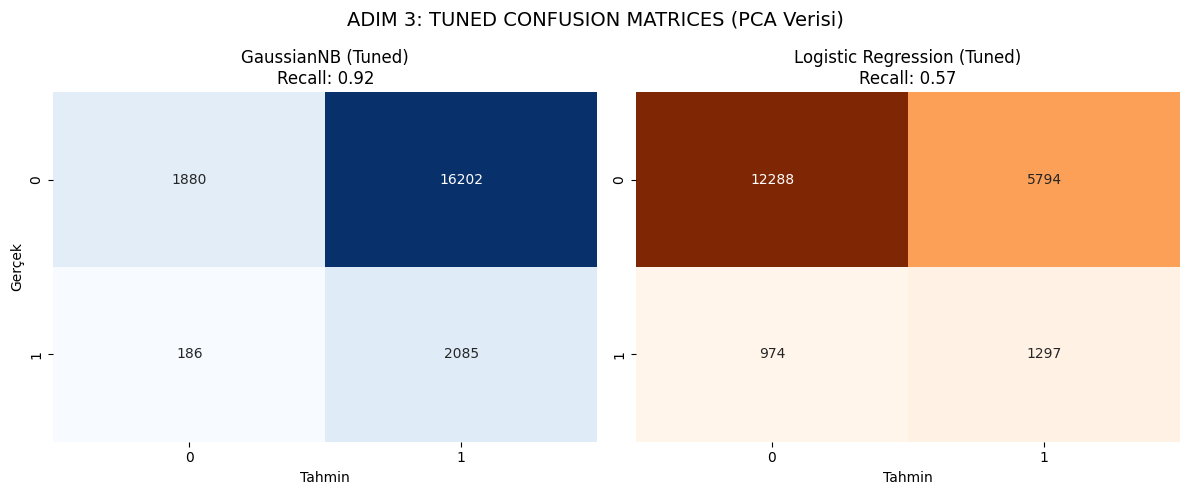

In [23]:
# MODELLERİ AYARLAMA (TUNING)
print("\n MODELLERİ AYARLAMA (TUNING)")
# En iyi Recall'u almak için PCA üzerinde Dengesizlik Çözümü + Tuning

# A. GaussianNB Tuning (PCA verisi üzerinde)
# Priors: Sınıf olasılıklarını dengeli (0.5, 0.5) olarak varsayarak dengesizliği giderme denemesi
gnb_tuned = GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-10)
gnb_tuned.fit(X_train_pca, y_train)
y_pred_gnb_tuned = gnb_tuned.predict(X_test_pca)
add_result('3. Tuning', 'GaussianNB', 'PCA + Balanced (Priors)', y_test, y_pred_gnb_tuned)

# B. Logistic Regression Tuning (PCA verisi üzerinde)
# class_weight='balanced': Sınıf dengesizliğini giderme
# C=0.1, penalty='l1': Düzenlileştirme ve daha az özellik kullanmaya teşvik etme
lr_tuned = LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear', penalty='l1', random_state=42)
lr_tuned.fit(X_train_pca, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test_pca)
add_result('3. Tuning', 'LogisticRegression', 'PCA + Balanced, C=0.1, L1', y_test, y_pred_lr_tuned)

# Görselleştirme (Tuned CM)
plot_side_by_side_cm(y_test, y_pred_gnb_tuned, "GaussianNB (Tuned)",
                     y_pred_lr_tuned, "Logistic Regression (Tuned)",
                     "ADIM 3: TUNED CONFUSION MATRICES (PCA Verisi)")


 SKOR TABLOSU (Recall'a Göre Sıralı) 


,Aşama,Model,Parametreler,Accuracy,Recall,F1 Score
0,1. Baseline,GaussianNB,Default,0.1311,0.9987,0.2041
1,2.1 Feature Sel.,GaussianNB,Top 50 Features,0.1353,0.9947,0.2043
2,3. Tuning,GaussianNB,PCA + Balanced (Priors),0.1948,0.9181,0.2028
3,2.2 Boyut Azaltma,GaussianNB,PCA (n=90),0.2404,0.8498,0.1998
4,3. Tuning,LogisticRegression,"PCA + Balanced, C=0.1, L1",0.6675,0.5711,0.2771
5,2.1 Feature Sel.,LogisticRegression,Top 50 Features,0.8884,0.0172,0.0332
6,1. Baseline,LogisticRegression,Default (C=1.0),0.8881,0.0163,0.0315
7,2.2 Boyut Azaltma,LogisticRegression,PCA (n=90),0.8880,0.0123,0.0240


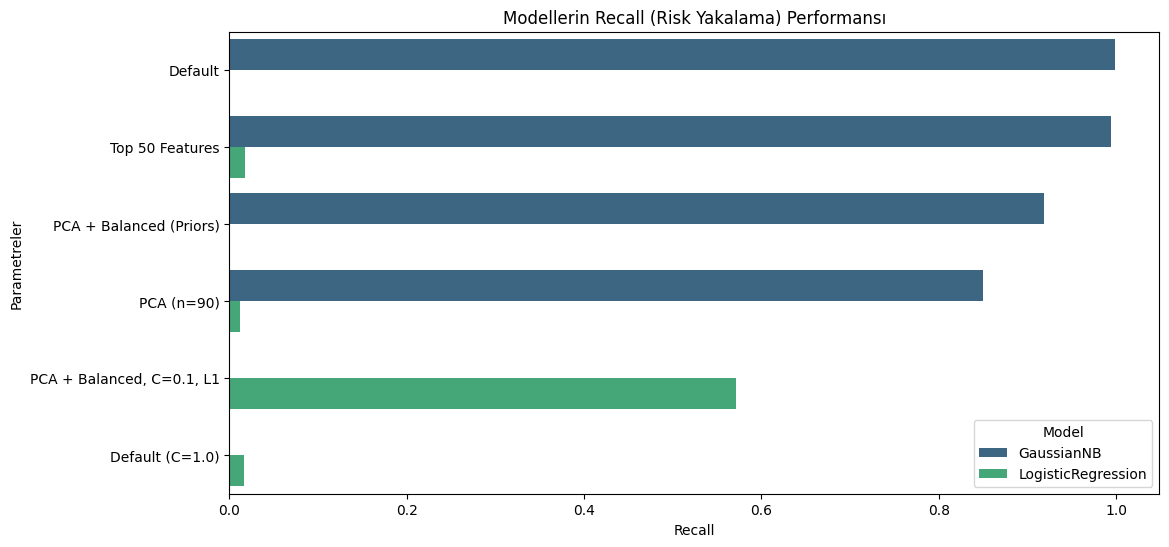


 EN İYİ DENEY: GaussianNB (Default)


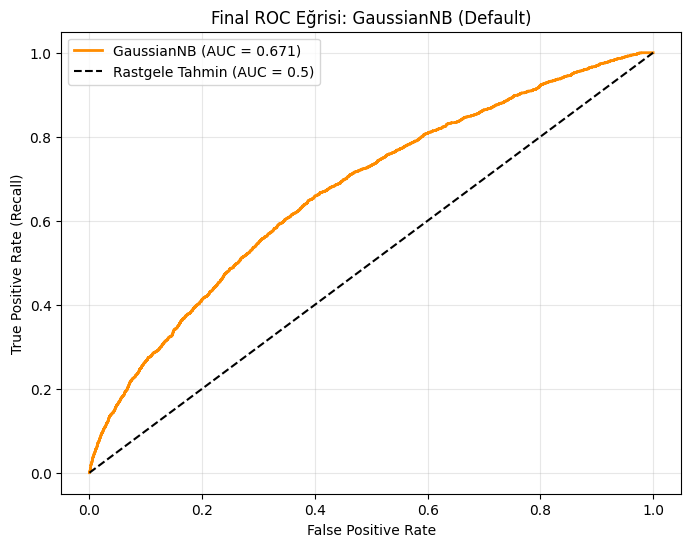


--- EN İYİ MODEL DETAYLI RAPORU ---
Model: GaussianNB | Ayar: Default
AUC Skoru: 0.6707
Maksimum F1 Skoru için Eşik: 0.5283
New F1 Score (Eşik Ayarlı):  0.2800
New Recall (Eşik Ayarlı):    0.4848
New Precision (Eşik Ayarlı): 0.1968


In [24]:
# SONUÇLARIN ÖZETİ VE EN İYİ MODELİN RAPORU

# Sonuçları Recall'a göre sırala
df_results = results_df.sort_values(by='Recall', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print(" SKOR TABLOSU (Recall'a Göre Sıralı) ")
print("="*60)
display(df_results)

# Grafik: Recall Karşılaştırması
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, y='Parametreler', x='Recall', hue='Model', palette='viridis')
plt.title('Modellerin Recall (Risk Yakalama) Performansı')
plt.show()

# En iyi modeli belirleme
best_model_row = df_results.iloc[0]
best_model_type = best_model_row['Model']
best_exp_name = best_model_row['Parametreler']

print(f"\n EN İYİ DENEY: {best_model_type} ({best_exp_name})")

# En iyi modeli temsil eden final pipeline'ı oluşturma (PCA'nın en iyi olduğu varsayımıyla)
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.90)),
    ('clf', LogisticRegression(class_weight='balanced', C=0.1, solver='liblinear', penalty='l1', random_state=42)) # En iyi model LR Tuned
])

# Tüm eğitim verisiyle son kez eğit
final_pipeline.fit(X_train, y_train)

# Test seti olasılıkları
y_probs_final = final_pipeline.predict_proba(X_test)[:, 1]

# --- ROC Eğrisi Çizimi ---
fpr, tpr, thresholds = roc_curve(y_test, y_probs_final)
auc_score = roc_auc_score(y_test, y_probs_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_type} (AUC = {auc_score:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'Final ROC Eğrisi: {best_model_type} ({best_exp_name})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- THRESHOLD AYARI VE SON RAPOR ---
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_final)

# F1 skorlarını hesapla
f1_scores = np.zeros_like(precision)
valid_indices = (precision + recall) != 0
f1_scores[valid_indices] = 2 * (precision[valid_indices] * recall[valid_indices]) / (precision[valid_indices] + recall[valid_indices])

# En iyi F1 skoru ve eşiğini bul
best_idx = np.nanargmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Yeni eşik ile tahmin yap
y_pred_new = (y_probs_final >= best_threshold).astype(int)

print("\n--- EN İYİ MODEL DETAYLI RAPORU ---")
print(f"Model: {best_model_type} | Ayar: {best_exp_name}")
print(f"AUC Skoru: {auc_score:.4f}")
print(f"Maksimum F1 Skoru için Eşik: {best_threshold:.4f}")
print(f"New F1 Score (Eşik Ayarlı):  {f1_score(y_test, y_pred_new):.4f}")
print(f"New Recall (Eşik Ayarlı):    {recall_score(y_test, y_pred_new):.4f}")
print(f"New Precision (Eşik Ayarlı): {precision_score(y_test, y_pred_new):.4f}")